In [1]:
!pip install scikit-plot optuna catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.1 MB/s eta 0:00:00


In [2]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

import os
#import scikitplot as skplt
import optuna

#models
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from xgboost import plot_importance


In [3]:
data=pd.read_csv('/content/data.csv')

In [4]:
data.head()

,CMPLNT_NUM,year,month,day,weekday,hour,Latitude,Longitude,COMPLETED,OFNS_DESC,...,JURISDICTION_CODE,IN_PARK,IN_PUBLIC_HOUSING,IN_STATION,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,303250435,2025,3,20,Thursday,0,40.75,-74.0,COMPLETED,SEXUAL,...,0,1,1,1,UNKNOWN,BLACK,M,25-44,WHITE,M
1,312320890,2025,9,3,Wednesday,22,0.00,0.0,COMPLETED,DRUGS/ALCOHOL,...,0,1,1,1,45-64,WHITE HISPANIC,M,UNKNOWN,UNKNOWN,E
2,307271594,2025,3,5,Wednesday,17,40.88,-73.9,COMPLETED,SEXUAL,...,0,1,1,1,25-44,BLACK,M,25-44,BLACK,F
3,299744592,2025,1,20,Monday,18,40.62,-74.2,COMPLETED,PROPERTY,...,0,1,1,1,UNKNOWN,BLACK HISPANIC,M,UNKNOWN,UNKNOWN,D
4,309582473,2025,7,12,Saturday,20,40.60,-74.1,COMPLETED,SEXUAL,...,0,1,1,1,UNKNOWN,WHITE,M,25-44,WHITE,F


In [5]:
data.columns

Index(['CMPLNT_NUM', 'year', 'month', 'day', 'weekday', 'hour', 'Latitude',
       'Longitude', 'COMPLETED', 'OFNS_DESC', 'ADDR_PCT_CD', 'CRIME_CLASS',
       'BORO_NM', 'PREM_TYP_DESC', 'OCCURENCE', 'JURIS_DESC',
       'JURISDICTION_CODE', 'IN_PARK', 'IN_PUBLIC_HOUSING', 'IN_STATION',
       'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'VIC_AGE_GROUP', 'VIC_RACE',
       'VIC_SEX'],
      dtype='object')

In [6]:
#example from the dataset
print(data.iloc[0])

CMPLNT_NUM                  303250435
year                             2025
month                               3
day                                20
weekday                      Thursday
hour                                0
Latitude                        40.75
Longitude                       -74.0
COMPLETED                   COMPLETED
OFNS_DESC                      SEXUAL
ADDR_PCT_CD                        13
CRIME_CLASS                    FELONY
BORO_NM                     MANHATTAN
PREM_TYP_DESC                HOSPITAL
OCCURENCE                      INSIDE
JURIS_DESC           N.Y. POLICE DEPT
JURISDICTION_CODE                   0
IN_PARK                             1
IN_PUBLIC_HOUSING                   1
IN_STATION                          1
SUSP_AGE_GROUP                UNKNOWN
SUSP_RACE                       BLACK
SUSP_SEX                            M
VIC_AGE_GROUP                   25-44
VIC_RACE                        WHITE
VIC_SEX                             M
Name: 0, dty

In [7]:
data.OFNS_DESC.unique()

array(['SEXUAL', 'DRUGS/ALCOHOL', 'PROPERTY', 'ADMINISTRATIVE', 'OTHER',
       'PERSONAL'], dtype=object)

In [8]:
filtered_df = data[~data['OFNS_DESC'].isin(['ADMINISTRATIVE', 'OTHER'])]
data=filtered_df
data.OFNS_DESC.unique()

array(['SEXUAL', 'DRUGS/ALCOHOL', 'PROPERTY', 'PERSONAL'], dtype=object)

In [9]:
# Create a dictionary to store the mapping
label_mapping = {}

# Original column values
original_values = data['OFNS_DESC'].unique()
label_encoder=LabelEncoder()
# Apply label encoding
data['target'] = label_encoder.fit_transform(data['OFNS_DESC'])

# New column values after label encoding
new_values = data['target'].unique()

# Populate the dictionary
label_mapping['original_to_encoded'] = dict(zip(original_values, new_values))
label_mapping['encoded_to_original'] = dict(zip(new_values, original_values))

# Print the dictionary
print(label_mapping)


{'original_to_encoded': {'SEXUAL': np.int64(3), 'DRUGS/ALCOHOL': np.int64(0), 'PROPERTY': np.int64(2), 'PERSONAL': np.int64(1)}, 'encoded_to_original': {np.int64(3): 'SEXUAL', np.int64(0): 'DRUGS/ALCOHOL', np.int64(2): 'PROPERTY', np.int64(1): 'PERSONAL'}}


In [10]:
data.columns

Index(['CMPLNT_NUM', 'year', 'month', 'day', 'weekday', 'hour', 'Latitude',
       'Longitude', 'COMPLETED', 'OFNS_DESC', 'ADDR_PCT_CD', 'CRIME_CLASS',
       'BORO_NM', 'PREM_TYP_DESC', 'OCCURENCE', 'JURIS_DESC',
       'JURISDICTION_CODE', 'IN_PARK', 'IN_PUBLIC_HOUSING', 'IN_STATION',
       'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'VIC_AGE_GROUP', 'VIC_RACE',
       'VIC_SEX', 'target'],
      dtype='object')

Balancing the data

In [11]:
min_count = data['target'].value_counts().min()

# Sample the same number of examples for each class
balanced_data = data.groupby('target').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

/tmp/ipython-input-1352695909.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = data.groupby('target').apply(lambda x: x.sample(min_count)).reset_index(drop=True)


In [12]:
balanced_data.target.value_counts()

,count
target,
0,17243
1,17243
2,17243
3,17243


# DATA PREPARATION
Choosing the columns that we will use in our Model

In [13]:
# Set the list of features to include in Machine Learning Model
feature_lst=['year', 'month', 'day', 'hour', 'Latitude',
       'Longitude', 'COMPLETED', 'ADDR_PCT_CD',
       'BORO_NM','IN_PARK', 'IN_PUBLIC_HOUSING',
       'IN_STATION', 'VIC_AGE_GROUP', 'VIC_RACE','VIC_SEX','target']

df_sel=data[feature_lst].copy()
df_sel.info()
df_sel.head()

<class 'pandas.core.frame.DataFrame'>
Index: 357542 entries, 0 to 438550
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   year               357542 non-null  int64  
 1   month              357542 non-null  int64  
 2   day                357542 non-null  int64  
 3   hour               357542 non-null  int64  
 4   Latitude           357542 non-null  float64
 5   Longitude          357542 non-null  float64
 6   COMPLETED          357542 non-null  object 
 7   ADDR_PCT_CD        357542 non-null  int64  
 8   BORO_NM            357542 non-null  object 
 9   IN_PARK            357542 non-null  int64  
 10  IN_PUBLIC_HOUSING  357542 non-null  int64  
 11  IN_STATION         357542 non-null  int64  
 12  VIC_AGE_GROUP      357542 non-null  object 
 13  VIC_RACE           357542 non-null  object 
 14  VIC_SEX            357542 non-null  object 
 15  target             357542 non-null  int64  
dtypes: floa

,year,month,day,hour,Latitude,Longitude,COMPLETED,ADDR_PCT_CD,BORO_NM,IN_PARK,IN_PUBLIC_HOUSING,IN_STATION,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,target
0,2025,3,20,0,40.75,-74.0,COMPLETED,13,MANHATTAN,1,1,1,25-44,WHITE,M,3
1,2025,9,3,22,0.00,0.0,COMPLETED,46,BRONX,1,1,1,UNKNOWN,UNKNOWN,E,0
2,2025,3,5,17,40.88,-73.9,COMPLETED,47,BRONX,1,1,1,25-44,BLACK,F,3
3,2025,1,20,18,40.62,-74.2,COMPLETED,121,STATEN ISLAND,1,1,1,UNKNOWN,UNKNOWN,D,2
4,2025,7,12,20,40.60,-74.1,COMPLETED,121,STATEN ISLAND,1,1,1,25-44,WHITE,F,3


In [14]:
completed_mapping={'COMPLETED':1,'ATTEMPTED':0}
# Apply the mapping to the COMPLETED column
df_sel['COMPLETED'] = df_sel['COMPLETED'].map(completed_mapping)



In [15]:
df_sel.head()

,year,month,day,hour,Latitude,Longitude,COMPLETED,ADDR_PCT_CD,BORO_NM,IN_PARK,IN_PUBLIC_HOUSING,IN_STATION,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,target
0,2025,3,20,0,40.75,-74.0,1,13,MANHATTAN,1,1,1,25-44,WHITE,M,3
1,2025,9,3,22,0.00,0.0,1,46,BRONX,1,1,1,UNKNOWN,UNKNOWN,E,0
2,2025,3,5,17,40.88,-73.9,1,47,BRONX,1,1,1,25-44,BLACK,F,3
3,2025,1,20,18,40.62,-74.2,1,121,STATEN ISLAND,1,1,1,UNKNOWN,UNKNOWN,D,2
4,2025,7,12,20,40.60,-74.1,1,121,STATEN ISLAND,1,1,1,25-44,WHITE,F,3


In [25]:
df_sel['IN_PUBLIC_HOUSING'].sum()

np.int64(357542)

In [16]:
print(df_sel.shape)
df_sel.target.value_counts().sort_values(ascending=False)


(357542, 16)


,count
target,
2,188341
1,77410
3,74548
0,17243


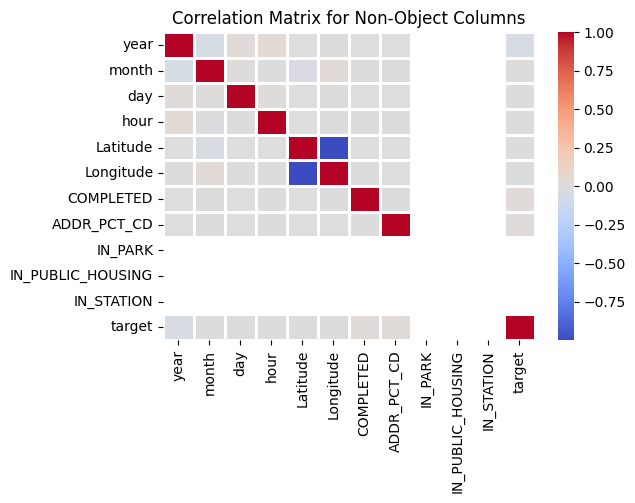

In [17]:
non_object_columns = df_sel.select_dtypes(exclude='object')

# Calculate correlation matrix
corr = non_object_columns.corr()

# Create a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, cmap="coolwarm", linewidth=2, linecolor="white",annot=False)
plt.title("Correlation Matrix for Non-Object Columns")
plt.show()

**Deal with categorical data**

In [18]:
df = pd.get_dummies(df_sel)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 357542 entries, 0 to 438550
Data columns (total 37 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   year                                     357542 non-null  int64  
 1   month                                    357542 non-null  int64  
 2   day                                      357542 non-null  int64  
 3   hour                                     357542 non-null  int64  
 4   Latitude                                 357542 non-null  float64
 5   Longitude                                357542 non-null  float64
 6   COMPLETED                                357542 non-null  int64  
 7   ADDR_PCT_CD                              357542 non-null  int64  
 8   IN_PARK                                  357542 non-null  int64  
 9   IN_PUBLIC_HOUSING                        357542 non-null  int64  
 10  IN_STATION                           

change the bool columns to uint8

In [19]:
bool_columns = df.select_dtypes(include='bool').columns

# Convert boolean columns to uint8
df[bool_columns] = df[bool_columns].astype('uint8')

In [ ]:
f.info()

<class 'pandas.core.frame.DataFrame'>
Index: 357542 entries, 0 to 438550
Data columns (total 37 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   year                                     357542 non-null  int64  
 1   month                                    357542 non-null  int64  
 2   day                                      357542 non-null  int64  
 3   hour                                     357542 non-null  int64  
 4   Latitude                                 357542 non-null  float64
 5   Longitude                                357542 non-null  float64
 6   COMPLETED                                357542 non-null  int64  
 7   ADDR_PCT_CD                              357542 non-null  int64  
 8   IN_PARK                                  357542 non-null  int64  
 9   IN_PUBLIC_HOUSING                        357542 non-null  int64  
 10  IN_STATION                           

In [ ]:
del df_sel
del data

# USEFUL FUNCTIONS

In [26]:
class_names = ['PROPERTY', 'PERSONAL', 'SEXUAL', 'DRUGS/ALCOHOL']

def plot_cm(y_pred, y_test, algorithm, figure_name, class_names=None):
    mat_RF = confusion_matrix(y_pred, y_test)

    # Define a custom color map
    cmap = sns.color_palette("pastel", as_cmap=True)  # You can choose any seaborn color palette

    plt.figure(figsize=(16, 4))
    sns.heatmap(mat_RF, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=class_names, yticklabels=class_names, cmap=cmap)

    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.title(algorithm)
    plt.savefig(figure_name)

In [27]:
def plot_roc(X_test,y_test, model, figure_name):
    pl = skplt.metrics.plot_roc(y_test, model.predict_proba(X_test), figsize=(12,6))
    plt.show()
    pl.figure.savefig(figure_name)

In [28]:
def save_model(model, model_name,is_tree=False):
    joblib.dump(model.estimators_[0] if is_tree else model,f'{model_name}.joblib')
    print(f"Model size: {np.round(os.path.getsize(f'{model_name}.joblib') / 1024 / 1024, 2) } MB")

# MODELING


In [29]:

# set X and y
y = df['target']
X = df.drop('target', axis=1)

In [30]:
y.head()


,target
0,3
1,0
2,3
3,2
4,3


In [31]:
X.head()
# we need to rename this features because XGBOOST can't accept feature which their name contains one of this ('>','<','[',']')
X.rename(columns={'VIC_AGE_GROUP_<18': 'VIC_AGE_GROUP_-18'}, inplace=True)


In [32]:
y.value_counts()

,count
target,
2,188341
1,77410
3,74548
0,17243


**split the data**

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,shuffle=True, random_state=42)


# FIRST MODEL: LGBM

In [34]:
def objective_lgbm(trial):
    # Define hyperparameters to be tuned
    params = {

        'objective': 'multiclass',
        'num_class':4 ,  # Number of classes
        'boosting_type': trial.suggest_categorical('boosting', ['gbdt']),
        'num_leaves': trial.suggest_int('num_leaves', 10, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'tree_method': 'gpu_hist',
    }

    # Create and train the LGBM model
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred = model.predict(X_test)

    # Evaluate the model using accuracy
    accuracy = accuracy_score(y_test, y_pred)

    return 1 - accuracy  # Optimize for accuracy, so use 1 - accuracy as the objective


In [35]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_lgbm, n_trials=10)

# Print the best parameters and their corresponding objective value
print("Best trial:")
trial = study.best_trial
print("  Value: {:.3f}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2026-01-12 18:29:53,669] A new study created in memory with name: no-name-b8aeffc6-ab4f-4425-8a74-13cf8a2ce621


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.22830907359486277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22830907359486277
[LightGBM] [Warning] bagging_fraction is set=0.6593736185693022, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6593736185693022
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.22830907359486277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22830907359486277
[LightGBM] [Warning] bagging_fraction is set=0.6593736185693022, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6593736185693022
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_f

[I 2026-01-12 18:30:22,544] Trial 0 finished with value: 0.41426760143198094 and parameters: {'boosting': 'gbdt', 'num_leaves': 166, 'learning_rate': 0.09706684216833808, 'feature_fraction': 0.22830907359486277, 'bagging_fraction': 0.6593736185693022, 'bagging_freq': 9, 'min_child_samples': 9}. Best is trial 0 with value: 0.41426760143198094.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.24707411992693157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24707411992693157
[LightGBM] [Warning] bagging_fraction is set=0.5197391680790983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5197391680790983
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.24707411992693157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24707411992693157
[LightGBM] [Warning] bagging_fraction is set=0.5197391680790983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5197391680790983
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_f

[I 2026-01-12 18:30:47,627] Trial 1 finished with value: 0.4146964498806682 and parameters: {'boosting': 'gbdt', 'num_leaves': 124, 'learning_rate': 0.07714613414844085, 'feature_fraction': 0.24707411992693157, 'bagging_fraction': 0.5197391680790983, 'bagging_freq': 4, 'min_child_samples': 10}. Best is trial 0 with value: 0.41426760143198094.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.6172855462544174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6172855462544174
[LightGBM] [Warning] bagging_fraction is set=0.6111101557691994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6111101557691994
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.6172855462544174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6172855462544174
[LightGBM] [Warning] bagging_fraction is set=0.6111101557691994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6111101557691994
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=

[I 2026-01-12 18:31:12,685] Trial 2 finished with value: 0.41219794152744627 and parameters: {'boosting': 'gbdt', 'num_leaves': 171, 'learning_rate': 0.058197790140803014, 'feature_fraction': 0.6172855462544174, 'bagging_fraction': 0.6111101557691994, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 2 with value: 0.41219794152744627.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.5703078693147784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5703078693147784
[LightGBM] [Warning] bagging_fraction is set=0.8702351879241985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8702351879241985
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.5703078693147784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5703078693147784
[LightGBM] [Warning] bagging_fraction is set=0.8702351879241985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8702351879241985
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=

[I 2026-01-12 18:31:42,513] Trial 3 finished with value: 0.41987992243436756 and parameters: {'boosting': 'gbdt', 'num_leaves': 124, 'learning_rate': 0.017309296888285197, 'feature_fraction': 0.5703078693147784, 'bagging_fraction': 0.8702351879241985, 'bagging_freq': 7, 'min_child_samples': 17}. Best is trial 2 with value: 0.41219794152744627.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.6313078242287603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6313078242287603
[LightGBM] [Warning] bagging_fraction is set=0.9853544070649558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9853544070649558
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.6313078242287603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6313078242287603
[LightGBM] [Warning] bagging_fraction is set=0.9853544070649558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9853544070649558
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=

[I 2026-01-12 18:32:11,271] Trial 4 finished with value: 0.41230981503579955 and parameters: {'boosting': 'gbdt', 'num_leaves': 126, 'learning_rate': 0.05237220649644904, 'feature_fraction': 0.6313078242287603, 'bagging_fraction': 0.9853544070649558, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 2 with value: 0.41219794152744627.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.17920626902131334, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17920626902131334
[LightGBM] [Warning] bagging_fraction is set=0.977234343719446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.977234343719446
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.17920626902131334, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17920626902131334
[LightGBM] [Warning] bagging_fraction is set=0.977234343719446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.977234343719446
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=

[I 2026-01-12 18:32:43,096] Trial 5 finished with value: 0.415833830548926 and parameters: {'boosting': 'gbdt', 'num_leaves': 167, 'learning_rate': 0.09392021407219524, 'feature_fraction': 0.17920626902131334, 'bagging_fraction': 0.977234343719446, 'bagging_freq': 7, 'min_child_samples': 11}. Best is trial 2 with value: 0.41219794152744627.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.24796246389259635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24796246389259635
[LightGBM] [Warning] bagging_fraction is set=0.7783020165047675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7783020165047675
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.24796246389259635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24796246389259635
[LightGBM] [Warning] bagging_fraction is set=0.7783020165047675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7783020165047675
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_f

[I 2026-01-12 18:33:03,234] Trial 6 finished with value: 0.42019689737470167 and parameters: {'boosting': 'gbdt', 'num_leaves': 22, 'learning_rate': 0.05963510372505901, 'feature_fraction': 0.24796246389259635, 'bagging_fraction': 0.7783020165047675, 'bagging_freq': 9, 'min_child_samples': 1}. Best is trial 2 with value: 0.41219794152744627.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.14262105821839136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14262105821839136
[LightGBM] [Warning] bagging_fraction is set=0.2930326107801663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2930326107801663
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.14262105821839136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14262105821839136
[LightGBM] [Warning] bagging_fraction is set=0.2930326107801663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2930326107801663
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_f

[I 2026-01-12 18:33:20,317] Trial 7 finished with value: 0.43748135441527447 and parameters: {'boosting': 'gbdt', 'num_leaves': 49, 'learning_rate': 0.03224065805094082, 'feature_fraction': 0.14262105821839136, 'bagging_fraction': 0.2930326107801663, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 2 with value: 0.41219794152744627.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.29170124568657607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29170124568657607
[LightGBM] [Warning] bagging_fraction is set=0.9543149269155055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9543149269155055
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.29170124568657607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29170124568657607
[LightGBM] [Warning] bagging_fraction is set=0.9543149269155055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9543149269155055
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_f

[I 2026-01-12 18:33:55,343] Trial 8 finished with value: 0.4224157219570406 and parameters: {'boosting': 'gbdt', 'num_leaves': 142, 'learning_rate': 0.02597940513814244, 'feature_fraction': 0.29170124568657607, 'bagging_fraction': 0.9543149269155055, 'bagging_freq': 7, 'min_child_samples': 9}. Best is trial 2 with value: 0.41219794152744627.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.9040874178480921, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9040874178480921
[LightGBM] [Warning] bagging_fraction is set=0.3286754117292434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3286754117292434
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] feature_fraction is set=0.9040874178480921, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9040874178480921
[LightGBM] [Warning] bagging_fraction is set=0.3286754117292434, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3286754117292434
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=

[I 2026-01-12 18:34:16,341] Trial 9 finished with value: 0.42398195107398573 and parameters: {'boosting': 'gbdt', 'num_leaves': 134, 'learning_rate': 0.01250915621333326, 'feature_fraction': 0.9040874178480921, 'bagging_fraction': 0.3286754117292434, 'bagging_freq': 2, 'min_child_samples': 20}. Best is trial 2 with value: 0.41219794152744627.


Best trial:
  Value: 0.412
  Params: 
    boosting: gbdt
    num_leaves: 171
    learning_rate: 0.058197790140803014
    feature_fraction: 0.6172855462544174
    bagging_fraction: 0.6111101557691994
    bagging_freq: 6
    min_child_samples: 8


In [36]:
newparams = {'boosting': 'gbdt', 'num_leaves': 189, 'learning_rate': 0.07136798356012823, 'feature_fraction': 0.6377744365605518, 'bagging_fraction': 0.11872885808571708, 'bagging_freq': 4, 'min_child_samples': 5}
print(newparams)

{'boosting': 'gbdt', 'num_leaves': 189, 'learning_rate': 0.07136798356012823, 'feature_fraction': 0.6377744365605518, 'bagging_fraction': 0.11872885808571708, 'bagging_freq': 4, 'min_child_samples': 5}


In [37]:
modellbg = lgb.LGBMClassifier(**newparams)
modellbg.fit(X_train, y_train)
y_pred = modellbg.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=0.6377744365605518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6377744365605518
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.11872885808571708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11872885808571708
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.6377744365605518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6377744365605518
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.11872885808571708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11872885

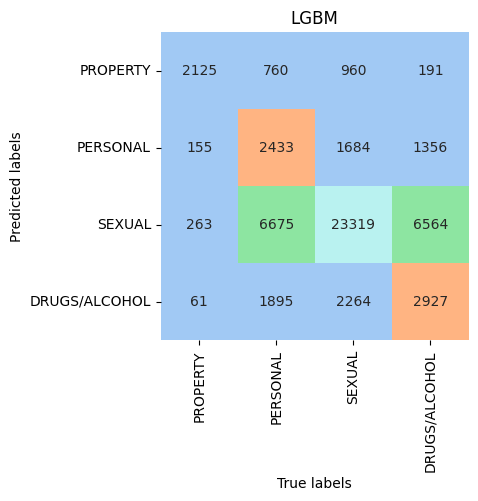

In [38]:
plot_cm(y_pred, y_test, 'LGBM', 'lgbm_confusion_matrix.jpg', class_names)


In [39]:
plot_roc(X_test,y_test, modellbg, 'lgbm_roc.jpg')

NameError: name 'skplt' is not defined

In [ ]:
accuracy = accuracy_score(y_pred, y_test)
print('lgbm Model accuracy score: {0:0.4f}'.format(accuracy_score(y_otte, y_pred)))

In [ ]:
class_report = classification_report(y_test, y_pred)
print(class_report)

In [ ]:
lgb.plot_importance(modellbg, importance_type='split', max_num_features=10)  # You can adjust max_num_features as needed
plt.show()

In [ ]:
save_model(modellbg, "lgbm")

# SECOND MODEL XGBOOST

**Hyperparams Tuning**

In [ ]:
def objective(trial):
    params = {
        'objective': 'multi:softmax',
        'num_class': 4,  # Assuming a classification task with 3 classes
        'eval_metric': 'mlogloss',
        'booster': 'gbtree',
        'tree_method' : "hist",
        'device' : "cuda",
        'verbosity': 1,
        'n_jobs': -1,  # Utilize all available CPU cores
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10)
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return mean_squared_error(y_test, y_pred, squared=False)

In [ ]:
# Create a study object and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10, n_jobs=4)

# Print the best parameters and their corresponding objective value
print("Best trial:")
trial = study.best_trial
print("  Value: {:.3f}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

**Training model with best hyperparams**

In [ ]:
bestparams = {
    'max_depth': 5,
    'learning_rate': 0.08282636175249172,
    'n_estimators': 60,
    'subsample': 0.4797848260397173,
    'colsample_bytree': 0.2619387039103879,
    'min_child_weight': 7.470308349969615,
    'objective': 'multi:softmax',  # Already included in your code
    'num_class': 6,               # Already included in your code
    'tree_method': 'gpu_hist',    # Enable GPU acceleration
    'predictor': 'gpu_predictor'  # Use GPU for prediction
}

modelxgb = xgb.XGBClassifier(**bestparams)
modelxgb.fit(X_train, y_train)
y_pred = modelxgb.predict(X_test)

**Evaluation**

In [ ]:
plot_cm(y_pred, y_test, 'xgboost', 'xgboost_confusion_matrix.jpg', class_names)


In [ ]:
plot_roc(X_test,y_test, modelxgb, 'xgboost_roc.jpg')

In [ ]:
class_report = classification_report(y_test, y_pred)
print(class_report)


In [ ]:
accuracy = accuracy_score(y_pred, y_test)
print('XGBBoost Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))


In [ ]:
plot_importance(modelxgb)
plt.show()

In [ ]:
save_model(modelxgb, "modelxgboost")

# THIRD MODEL : CATBBOST

In [ ]:
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 2000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'loss_function': 'MultiClass',
        'verbose': 0,
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose_eval=False)
    y_pred = model.predict(X_test)

    return mean_squared_error(y_test, y_pred, squared=False)


In [ ]:
study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=10)

# Print the best parameters and their corresponding objective value for CatBoost
print("Best trial for CatBoost:")
trial_catboost = study_catboost.best_trial
print("  Value: {:.3f}".format(trial_catboost.value))
print("  Params: ")
for key, value in trial_catboost.params.items():
    print("    {}: {}".format(key, value))


In [ ]:
"""best_params_catboost = {
    'iterations': trial_catboost.params['iterations'],
    'depth': trial_catboost.params['depth'],
    'learning_rate': trial_catboost.params['learning_rate'],
    'l2_leaf_reg': trial_catboost.params['l2_leaf_reg'],
    'border_count': trial_catboost.params['border_count'],
    'colsample_bylevel': trial_catboost.params['colsample_bylevel'],
    'min_child_samples': trial_catboost.params['min_child_samples'],
    'loss_function': 'MultiClass',
    'num_class': 4,
    'verbose': 0,
}"""

best_params_catboost = {
    'iterations': 1200,
    'depth': 7,
    'learning_rate': 0.08,
    'l2_leaf_reg': 4,
    'border_count': 198,
    'colsample_bylevel':0.44,
    'min_child_samples': 12,
    'loss_function': 'MultiClass',
    'verbose': 0,
}

print(best_params_catboost)

In [ ]:
# Use the best parameters to train the CatBoost model
model_catboost = CatBoostClassifier(**best_params_catboost)
model_catboost.fit(X_train, y_train, eval_set=(X_test, y_test), verbose_eval=False)
y_pred_catboost = model_catboost.predict(X_test)


In [ ]:
cm = confusion_matrix(y_test, y_pred_catboost)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
plot_roc(X_test, y_test, model_catboost, 'catboost_roc.jpg')


In [ ]:
class_report_catboost = classification_report(y_test, y_pred_catboost)
print(class_report_catboost)

In [ ]:
print(mean_squared_error(y_test, y_pred_catboost, squared=False))
accuracy_catboost = accuracy_score(y_pred_catboost, y_test)
print('CatBoost Model accuracy score: {0:0.4f}'.format(accuracy_catboost))

In [ ]:
save_model(model_catboost, "model_catboost")